In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math

import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF

# append source
import os, sys

partial_equiv_source = os.path.join(os.getcwd(), '..')
if partial_equiv_source not in sys.path:
    sys.path.append(partial_equiv_source)

from partial_equiv.partial_gconv.conv import LiftingConv, GroupConv
import partial_equiv.groups as groups

# visualization_utilities
from visualization_utils import (
    visualize_lifting_coordinate_grids, visualize_lifting_kernels,
    visualize_group_coordinate_grids, visualize_group_kernels,
    visualize_activations,
)

In [3]:
device = 'cpu'
plt.rcParams['figure.figsize'] = [20, 10]

In [4]:
from omegaconf import OmegaConf

# Get the template of the config file used in the experiments
config_template = OmegaConf.load(os.path.join(partial_equiv_source, 'cfg/config.yaml'))

# Get templates of the config files for the group, kernel and conv.
group_config = config_template.base_group
kernel_config = config_template.kernel
conv_config = config_template.conv

In [92]:
# Modify them

# Group
group_config.no_samples = 8
group_config.sampling_method = groups.SamplingMethods.DETERMINISTIC
print(OmegaConf.to_yaml(group_config))

# Kernel
kernel_config.type = "SIREN"
kernel_config.no_hidden = 32
kernel_config.no_layers = 3
kernel_config.size = "7"
kernel_config.omega0 = 10.0
print(OmegaConf.to_yaml(kernel_config))

# Conv
conv_config.padding = "same"
conv_config.partial_equiv = False
print(OmegaConf.to_yaml(conv_config))

name: ''
no_samples: 8
sample_per_batch_element: false
sample_per_layer: false
sampling_method: DETERMINISTIC
gumbel_init_temp: 1.0
gumbel_end_temp: 0.0001

type: SIREN
no_hidden: 32
no_layers: 3
size: '7'
omega0: 10.0
learn_omega0: false
weight_norm: false

padding: same
partial_equiv: false
bias: true



In [93]:
group = groups.SE2(gumbel_init_temperature=1e-4, gumbel_end_temperature=1e-4, gumbel_no_iterations= 1000)

liftconv = LiftingConv(
    in_channels=1,
    out_channels=20,
    group=group,
    base_group_config=group_config,
    kernel_config=kernel_config,
    conv_config=conv_config,
)

gconv = GroupConv(
    in_channels=20,
    out_channels=5,
    group=group,
    base_group_config=group_config,
    kernel_config=kernel_config,
    conv_config=conv_config,
)
liftconv, gconv = liftconv.to(device), gconv.to(device)

# Test with full equivariance

First, we see how the representations behave with full equivariance. Then, we replace the gconv.probs value to be 0.5 and evaluate the difference in the representations.

In [94]:
gconv.probs.data = 100.0 * gconv.probs.data
gconv.probs

tensor([100., 100., 100., 100., 100., 100., 100.])

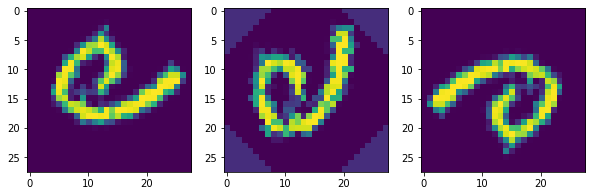

In [95]:
from datasets import RotatedMNIST
from torch.utils.data import Dataset, DataLoader

training_set = RotatedMNIST(
        partition="train",
        augment="None",
        root=os.path.join(os.path.dirname(os.getcwd()), "data"),
)

training_loader = DataLoader(
    training_set,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

# obtain a set of samples
samples, _ = next(iter(training_loader))
# rotate the set of samples
samples_rot_45 = TF.rotate(samples, 45)
samples_rot_180 = TF.rotate(samples, 180)
# flip the set of samples
samples_flip = torch.flip(samples, [-2])

no_rows = 1
no_cols = 3

fig = plt.figure(figsize=(10,15))
ax_1 = fig.add_subplot(1, 3, 1)
ax_1.imshow(samples[0, 0, :, :])
ax_1 = fig.add_subplot(1, 3, 2)
ax_1.imshow(samples_rot_45[0, 0, :, :])
ax_1 = fig.add_subplot(1, 3, 3)
ax_1.imshow(samples_rot_180[0, 0, :, :])

plt.show()

In [96]:
lifting_conv_acts, grid_H_lift = liftconv(samples)
lifting_conv_acts = torch.relu(lifting_conv_acts)
group_conv_acts, grid_H = gconv([lifting_conv_acts, grid_H_lift])
print(grid_H), print(grid_H_lift)

tensor([[0.0000, 0.7854, 1.5708, 2.3562, 3.1416, 3.9270, 4.7124, 5.4978]],
       dtype=torch.float64)
tensor([[0.0000, 0.7854, 1.5708, 2.3562, 3.1416, 3.9270, 4.7124, 5.4978]],
       dtype=torch.float64)


(None, None)

In [99]:
lifting_conv_acts_rot_45, grid_H_lift = liftconv(samples_rot_45)
lifting_conv_acts_rot_45 = torch.relu(lifting_conv_acts_rot_45)
group_conv_acts_rot_45, grid_H = gconv([lifting_conv_acts_rot_45, grid_H_lift])
print(grid_H), print(grid_H_lift)

tensor([[0.0000, 0.7854, 1.5708, 2.3562, 3.1416, 3.9270, 4.7124, 5.4978]],
       dtype=torch.float64)
tensor([[0.0000, 0.7854, 1.5708, 2.3562, 3.1416, 3.9270, 4.7124, 5.4978]],
       dtype=torch.float64)


(None, None)

In [102]:
lifting_conv_acts_rot_180, grid_H_lift = liftconv(samples_rot_180)
lifting_conv_acts_rot_180 = torch.relu(lifting_conv_acts_rot_180)
group_conv_acts_rot_180, grid_H = gconv([lifting_conv_acts_rot_180, grid_H_lift])
print(grid_H), print(grid_H_lift)

tensor([[0.0000, 0.7854, 1.5708, 2.3562, 3.1416, 3.9270, 4.7124, 5.4978]],
       dtype=torch.float64)
tensor([[0.0000, 0.7854, 1.5708, 2.3562, 3.1416, 3.9270, 4.7124, 5.4978]],
       dtype=torch.float64)


(None, None)

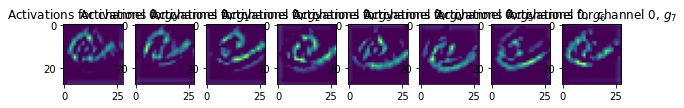

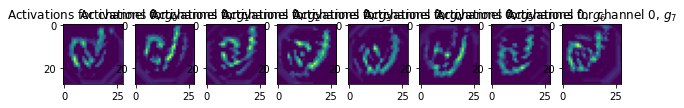

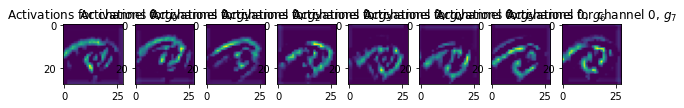

In [103]:
visualize_activations(lifting_conv_acts.detach().numpy())
visualize_activations(lifting_conv_acts_rot_45.detach().numpy())
visualize_activations(lifting_conv_acts_rot_180.detach().numpy())

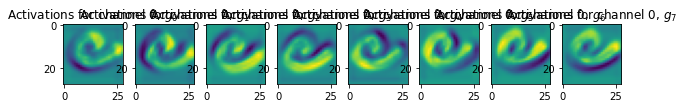

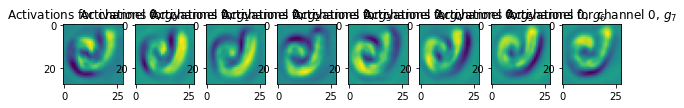

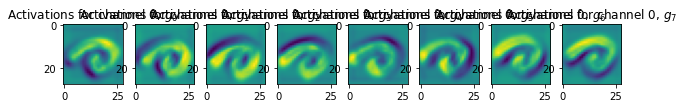

In [105]:
visualize_activations(group_conv_acts.detach().numpy())
visualize_activations(group_conv_acts_rot_45.detach().numpy())
visualize_activations(group_conv_acts_rot_180.detach().numpy())

### Partial equivariance
Now, we modify the conv.probs and sample one some of these values: Namely rotations on the upper circle.

In [53]:
gconv.probs.data[2:5] = -10000.
print(gconv.probs)
# This are the probabilities of sampling: 45, 90, 135, 180, 235, 270, and 315 grades respectively. If we set the under circle to be low, we will be much less likely to sample them.

Parameter containing:
tensor([ 10000.,  10000., -10000., -10000., -10000.,  10000.,  10000.],
       requires_grad=True)


In [70]:
group_conv_acts, grid_H = gconv([lifting_conv_acts, grid_H_lift])
print(grid_H), print(grid_H_lift)

tensor([[0.0000, 0.7854, 1.5708, 3.1416, 3.9270]], dtype=torch.float64,
       grad_fn=<RemainderBackward0>)
tensor([[0.0000, 0.7854, 1.5708, 2.3562, 3.1416, 3.9270, 4.7124, 5.4978]],
       dtype=torch.float64)


(None, None)

In [71]:
group_conv_acts_rot, grid_H = gconv([lifting_conv_acts_rot, grid_H_lift])
print(grid_H), print(grid_H_lift)

tensor([[0.0000, 0.7854, 1.5708, 3.1416, 4.7124, 5.4978]], dtype=torch.float64,
       grad_fn=<RemainderBackward0>)
tensor([[0.0000, 0.7854, 1.5708, 2.3562, 3.1416, 3.9270, 4.7124, 5.4978]],
       dtype=torch.float64)


(None, None)

In [72]:
# We put away those we dont need in the combination. We keep only the first 3.
group_conv_acts_rot = group_conv_acts_rot[:, :, :3, :, :]
group_conv_acts = group_conv_acts[:, :, :3, :, :]

In [74]:
print(group_conv_acts.shape), print(group_conv_acts_rot.shape)

torch.Size([32, 5, 3, 28, 28])
torch.Size([32, 5, 3, 28, 28])


(None, None)

In [75]:
def visualize_activations(acts, channel_idx=0, sample_idx=0):
    """Visualize the activations throughout the network.
    :param acts: tensor of activations with shape [batch_dim, out_channels, group_dim, spatial_1, spatial_2]
    :param channel_idx: integer, determines which of the output channels to visualize over the groups
    :param sample_idx: integer, determines which of the samples to visualize for
    :return: None
    """
    act = acts[sample_idx, channel_idx, :, :, :]

    no_rows = 1
    no_cols = math.floor(len(act))

    fig = plt.figure()

    for group_elem in range(len(act)):
        ax = fig.add_subplot(no_rows, no_cols, group_elem + 1)

        ax.imshow(act[group_elem, :, :])
        ax.set_title(f"Activations for channel {channel_idx}, $g_{group_elem}$")

    plt.show()

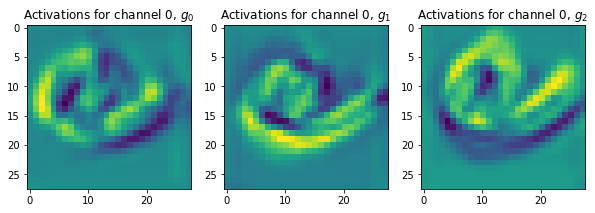

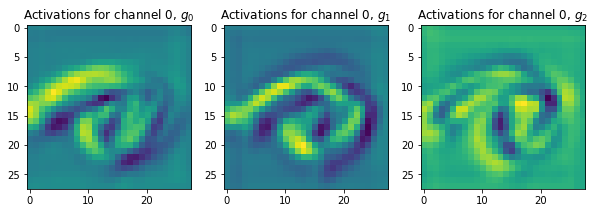

In [76]:
plt.rcParams['figure.figsize'] = [10, 5]
visualize_activations(group_conv_acts.detach().numpy())
visualize_activations(group_conv_acts_rot.detach().numpy())

As we see, the representations heavily change for rotations outside of the manifold.